In [1]:
%matplotlib inline
#mpld3.enable_notebook()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import seaborn as sns

In [2]:
# Load in merged hourly data
netcdf_file = r'F:\Work\e\Data\Obs\Canada_Project_Sites\CSAS_data\QC\Hourly_QC.nc'
ds = xr.open_dataset(netcdf_file)
# Load in point data
ds_point = xr.open_dataset(r'F:\Work\e\Data\Obs\Canada_Project_Sites\CSAS_data\EC_Snow_Courses\netcdf\EC_Snow_Courses.nc') # MST
# Load in dem
dem_file = r'F:\Work\e\Data\DEMs\NA.tif'
dem = xr.open_rasterio(dem_file).sel(band=1).drop('band')
# Provences 
p_file = r'F:\Work\e\Data\Shape_files\CAN_adm1.shp'

In [3]:
# Trim down ds (its big)
ds = ds[['SnowWaterEquivelentA','SnowDepthA']]
ds

<xarray.Dataset>
Dimensions:               (Time_UTC: 296916, staID: 261)
Coordinates:
  * staID                 (staID) object '05AA801' '05AA804' '05AA808' ...
  * Time_UTC              (Time_UTC) datetime64[ns] 1983-12-07T04:00:00 ...
    Elevation             (staID) float64 1.52e+03 1.393e+03 1.676e+03 ...
    Lat                   (staID) float64 49.28 49.42 49.8 49.36 50.09 49.67 ...
    network               (staID) object 'ABE_AGG_HIST' 'ABE_AGG_HIST' ...
    station_name          (staID) object 'Westcastle II' ...
    Lon                   (staID) float64 -114.4 -114.1 -114.5 -114.5 -114.6 ...
Data variables:
    SnowWaterEquivelentA  (Time_UTC, staID) float64 nan nan nan nan nan nan ...
    SnowDepthA            (Time_UTC, staID) float64 nan nan nan nan nan nan ...

In [4]:
ds

<xarray.Dataset>
Dimensions:               (Time_UTC: 296916, staID: 261)
Coordinates:
  * staID                 (staID) object '05AA801' '05AA804' '05AA808' ...
  * Time_UTC              (Time_UTC) datetime64[ns] 1983-12-07T04:00:00 ...
    Elevation             (staID) float64 1.52e+03 1.393e+03 1.676e+03 ...
    Lat                   (staID) float64 49.28 49.42 49.8 49.36 50.09 49.67 ...
    network               (staID) object 'ABE_AGG_HIST' 'ABE_AGG_HIST' ...
    station_name          (staID) object 'Westcastle II' ...
    Lon                   (staID) float64 -114.4 -114.1 -114.5 -114.5 -114.6 ...
Data variables:
    SnowWaterEquivelentA  (Time_UTC, staID) float64 nan nan nan nan nan nan ...
    SnowDepthA            (Time_UTC, staID) float64 nan nan nan nan nan nan ...

In [5]:
lat_r = ds.Lat.max()-ds.Lat.min()
lon_r = ds.Lon.max()-ds.Lon.min()
bdy = 0.2
box = [ds.Lon.min()-lon_r*bdy, ds.Lon.max()+lon_r*bdy, ds.Lat.min()-lat_r*bdy, ds.Lat.max()+lat_r*bdy]
# box = [ds.Lon.min(), ds.Lon.max(), ds.Lat.min(), ds.Lat.max()]

In [6]:
box

[<xarray.DataArray 'Lon' ()>
 array(-133.96894799999998), <xarray.DataArray 'Lon' ()>
 array(-108.025485), <xarray.DataArray 'Lat' ()>
 array(47.031733333999995), <xarray.DataArray 'Lat' ()>
 array(59.388599996)]

In [7]:
# Set nan in dem
dem = dem.where(dem>0)
dem = dem.where((dem.x>box[0]) & (dem.x<box[1]) & (dem.y>box[2]) & (dem.y<box[3]), drop=True)

In [8]:
p_sh = list(shpreader.Reader(p_file).geometries())

In [9]:
cmap_elev = mpl.colors.ListedColormap(sns.color_palette("Greys", 10))
cmap_network = {'bcRiverForecastCenter':'r', 'environmentAlberta':'k','CRHO':'b','ABE_AGG_HIST':'g'}

In [10]:
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=2, rc={"lines.linewidth": 2})

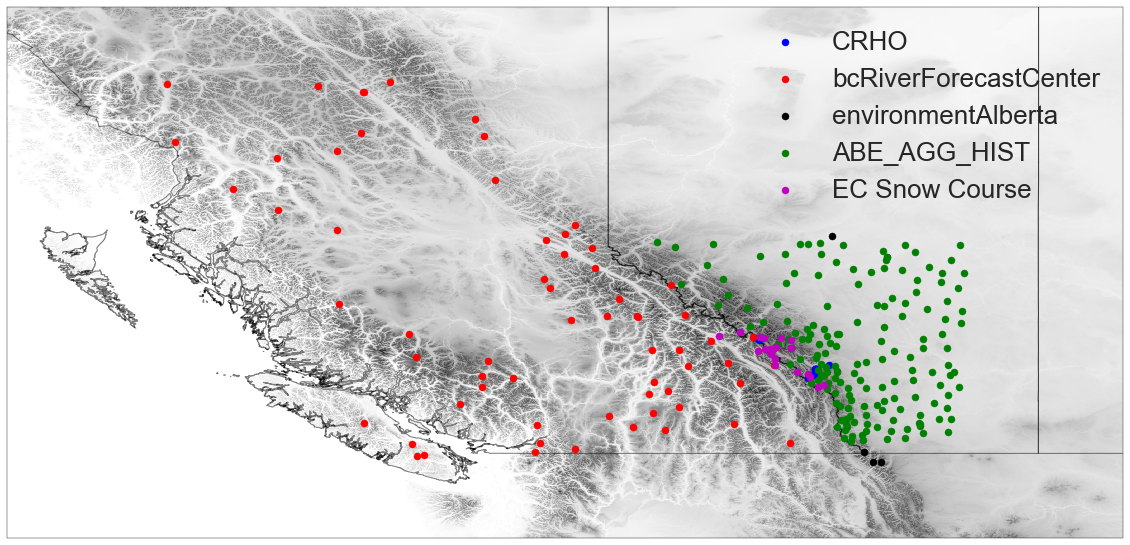

In [11]:
fig = plt.figure(figsize=(20, 20))
ax1 = plt.axes(projection=ccrs.AlbersEqualArea())
# ax1.set_extent(box)
ax1.imshow(np.flipud(dem.values), extent=[np.min(dem.x), np.max(dem.x),
                                             np.min(dem.y), np.max(dem.y)], aspect=ax1.get_aspect())
# ax1.set_title('Elevation')
for c_net in set(ds.network.values):
    lat_pts = ds.Lat.sel(staID=(ds.where(ds.network==c_net, drop=True).network).staID).values
    lon_pts = ds.Lon.sel(staID=(ds.where(ds.network==c_net, drop=True).network).staID).values
    I_not_nan = ~np.isnan(lat_pts) & ~np.isnan(lon_pts)
    lat_pts = lat_pts[I_not_nan]
    lon_pts = lon_pts[I_not_nan]
    
    ax1.scatter(lon_pts, lat_pts, transform=ccrs.AlbersEqualArea(), s=50, c=cmap_network[c_net], zorder=100, label=c_net) #yc, xc -- lists or numpy arrays

# Snow Courses
lat_pts = ds_point.Lat.values
lon_pts = ds_point.Lon.values
I_not_nan = ~np.isnan(lat_pts) & ~np.isnan(lon_pts)
lat_pts = lat_pts[I_not_nan]
lon_pts = lon_pts[I_not_nan]

ax1.scatter(lon_pts, lat_pts, transform=ccrs.AlbersEqualArea(), marker='o', s=50, c='m', zorder=200, label='EC Snow Course') #yc, xc -- lists or numpy arrays

    
ax1.add_geometries(p_sh, ccrs.AlbersEqualArea(),
                  edgecolor='black', facecolor='none', alpha=0.5)
plt.legend()

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax1 = plt.axes(projection=ccrs.AlbersEqualArea())
# ax1.set_extent(box)
ax1.imshow(np.flipud(dem.values), extent=[np.min(dem.x), np.max(dem.x),
                                             np.min(dem.y), np.max(dem.y)], aspect=ax1.get_aspect())
ax1.set_extent([-119.135830621329, -113.91715780976, 50.7467287151959, 51.2770940589401])
# ax1.set_title('Elevation')
for c_net in set(ds.network.values):
    lat_pts = ds.Lat.sel(staID=(ds.where(ds.network==c_net, drop=True).network).staID).values
    lon_pts = ds.Lon.sel(staID=(ds.where(ds.network==c_net, drop=True).network).staID).values
    I_not_nan = ~np.isnan(lat_pts) & ~np.isnan(lon_pts)
    lat_pts = lat_pts[I_not_nan]
    lon_pts = lon_pts[I_not_nan]
    
    ax1.scatter(lon_pts, lat_pts, transform=ccrs.AlbersEqualArea(), s=50, c=cmap_network[c_net], zorder=100, label=c_net) #yc, xc -- lists or numpy arrays

ax1.add_geometries(p_sh, ccrs.AlbersEqualArea(),
                  edgecolor='black', facecolor='none', alpha=0.5)
plt.legend()

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax1 = plt.axes(projection=ccrs.AlbersEqualArea())
# ax1.set_extent(box)
ax1.imshow(np.flipud(dem.values), extent=[np.min(dem.x), np.max(dem.x),
                                             np.min(dem.y), np.max(dem.y)], aspect=ax1.get_aspect())

swe_max = ds.SnowWaterEquivelentA.max(dim='Time_UTC')
lat_pts = swe_max.Lat.values
lon_pts = swe_max.Lon.values

I_not_nan = ~np.isnan(lat_pts) & ~np.isnan(lon_pts) & ~np.isnan(swe_max.values)
lat_pts = lat_pts[I_not_nan]
lon_pts = lon_pts[I_not_nan]
c_swe   = swe_max[I_not_nan].values
cmapblues = mpl.colors.ListedColormap(sns.color_palette("Reds", 10))


p1 = ax1.scatter(lon_pts, lat_pts, transform=ccrs.AlbersEqualArea(), s=50, c=c_swe, cmap=cmapblues, zorder=100) #yc, xc -- lists or numpy arrays

ax1.add_geometries(p_sh, ccrs.AlbersEqualArea(),
                  edgecolor='black', facecolor='none', alpha=0.5)
c0 = fig.colorbar(p1, ax=ax1, orientation="vertical", label='Peak SnowWaterEquivelentA (m)')

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax1 = plt.axes(projection=ccrs.AlbersEqualArea())
# ax1.set_extent(box)
ax1.imshow(np.flipud(dem.values), extent=[np.min(dem.x), np.max(dem.x),
                                             np.min(dem.y), np.max(dem.y)], aspect=ax1.get_aspect())

swe_mean = ds.SnowWaterEquivelentA.mean(dim='Time_UTC')
swe_mean = swe_mean.where((swe_mean.Lat>50.7467287151959) & (swe_mean.Lat<51.2770940589401) & 
                          (swe_mean.Lon>-119.135830621329) & (swe_mean.Lon<-113.917157809765), drop=True)
lat_pts = swe_mean.Lat.values
lon_pts = swe_mean.Lon.values

I_not_nan = ~np.isnan(lat_pts) & ~np.isnan(lon_pts) & ~np.isnan(swe_mean.values)
lat_pts = lat_pts[I_not_nan]
lon_pts = lon_pts[I_not_nan]
c_swe   = swe_mean[I_not_nan].values
cmapblues = mpl.colors.ListedColormap(sns.color_palette("Reds", 10))


p1 = ax1.scatter(lon_pts, lat_pts, transform=ccrs.AlbersEqualArea(), s=50, c=c_swe, cmap=cmapblues, zorder=100) #yc, xc -- lists or numpy arrays

ax1.add_geometries(p_sh, ccrs.AlbersEqualArea(),
                  edgecolor='black', facecolor='none', alpha=0.5)
c0 = fig.colorbar(p1, ax=ax1, orientation="vertical", label='Mean SnowWaterEquivelentA (m)')
print(swe_mean.min().values)
print(swe_mean.mean().values)
print(swe_mean.max().values)
                        

In [ ]:
X = ds.SnowWaterEquivelentA.where((swe_mean.Lat>50.7467287151959) & (swe_mean.Lat<51.2770940589401) & 
                          (swe_mean.Lon>-119.135830621329) & (swe_mean.Lon<-113.917157809765), drop=True)
X.station_name

In [ ]:
plt.figure()
for staID in X.staID:
    if X.sel(staID=staID).sum() > 0:
        plt.plot(ds.Time_UTC, X.sel(staID=staID), label=staID.station_name.values)
plt.legend()